In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
sys.path.insert(0, '../source/')
from plot_utils import *
from preprocess_data_utils import *
import time

In [2]:
snIa = pd.read_pickle("../data/training/raw/lcs_Ia_salt2_000000.pkl")
snIbc = pd.read_pickle("../data/training/raw/lcs_Ibc_nugent_000000.pkl")
snIIn = pd.read_pickle("../data/training/raw/lcs_IIn_nugent_000000.pkl")
snIIp = pd.read_pickle("../data/training/raw/lcs_IIP_nugent_000000.pkl")


In [3]:
snIa_lcs = snIa["lcs"]
snIbc_lcs = snIbc["lcs"]
snIIn_lcs = snIIn["lcs"]
snIIp_lcs = snIIp["lcs"]

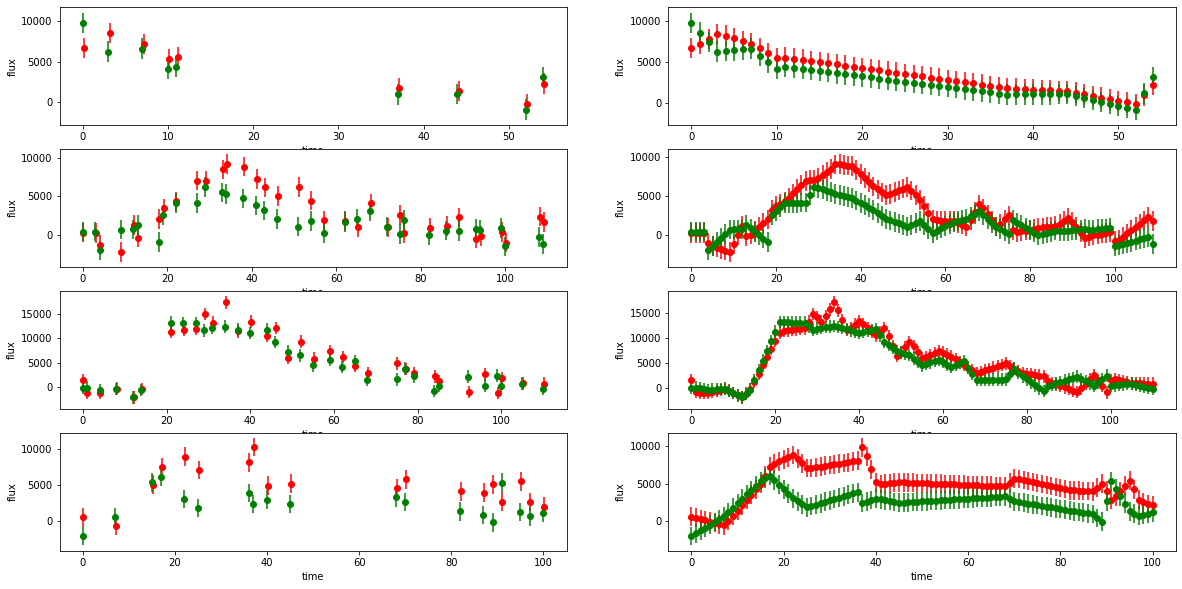

In [4]:
def plot_some_lcs(lcs, rows, cols):
    fig, axs = plt.subplots(rows, cols,figsize=(20,10))
    #split into bands
    count = 0
    
    for i in np.arange(rows):            
            r=np.array(list(filter(lambda p: p["band"]=='ztfr' , lcs[count])))
            g=np.array(list(filter(lambda p: p["band"]=='ztfg' , lcs[count])))
    
            r_t = np.array(list(map(lambda p: p["time"], r)))
            r_f = np.array(list(map(lambda p: p["flux"], r)))
            r_e = np.array(list(map(lambda p: p["fluxerr"], r)))

            g_t = np.array(list(map(lambda p: p["time"], g)))
            g_f = np.array(list(map(lambda p: p["flux"], g)))
            g_e = np.array(list(map(lambda p: p["fluxerr"], g)))
   
            count += 1
           # print(g_t)
           # print(r_t[0])
            
            t_0= g_t[0] if g_t[0]< r_t[0] else r_t[0]
            r_t = r_t-t_0
            g_t = g_t-t_0
            #print(g_t)
            period = np.max(r_t) if np.max(g_t)< np.max(r_t) else np.max(g_t)
            period = int(period+1)
            #print(period)
            
            axs[i][0].errorbar(r_t, r_f, yerr= r_e,fmt='ro')
            axs[i][0].errorbar(g_t, g_f, yerr= g_e,fmt='go')
            
            x_interp = np.arange(period)
            new_r = np.interp(x_interp, r_t, r_f)
            new_r_e = np.interp(x_interp,r_t,r_e)
            new_g = np.interp(x_interp, g_t, g_f)
            new_g_e = np.interp(x_interp,g_t,g_e)
            
            axs[i][1].errorbar(x_interp,new_r,yerr= new_r_e,fmt='ro')
            axs[i][1].errorbar(x_interp,new_g,yerr= new_g_e,fmt='go')
    for ax in axs.flat:
        ax.set(xlabel='time', ylabel='flux')


#plot a few random lightcurves and their interpolations, one of each type
rows = 4
cols = 2

snIa_lc = snIa_lcs[np.random.randint(0,len(snIa_lcs))]
snIbc_lc = snIbc_lcs[np.random.randint(0,len(snIbc_lcs))]
snIIn_lc = snIIn_lcs[np.random.randint(0,len(snIIn_lcs))]
snIIp_lc = snIIp_lcs[np.random.randint(0,len(snIIp_lcs))]
#snIbc_lc = [snIbc_lcs[i] for i in np.random.randint(0,len(snIbc_lcs))]
samples = [snIa_lc, snIbc_lc, snIIn_lc, snIIp_lc]
plot_some_lcs(samples,rows,cols)


In [5]:
sn_lcs = [snIa_lcs, snIbc_lcs, snIIn_lcs, snIIp_lcs]
sn_lcs_flat= [item for sublist in sn_lcs for item in sublist]

In [4]:
len(snIa_lcs)

17689

In [5]:
def lcs_to_df(lcs, first_id = 0):
    df = pd.DataFrame(data=lcs, dtype=np.int8)
    df_sn = df.stack(dropna=True)
    df_sn = df_sn.to_frame()
    df_sn.reset_index(level=0, inplace=True)
    df_sn=df_sn.rename(columns={"level_0": "id", 0: "X"})
    df_sn["id"]= df_sn["id"]+first_id
    df_sn["time"] = df_sn["X"].str[0]
    df_sn["band"] = df_sn["X"].str[1]
    df_sn["flux"] = df_sn["X"].str[2]
    df_sn["fluxerr"] = df_sn["X"].str[3]
    df_sn= df_sn.drop("X",axis=1)
    df_sn=df_sn[df_sn.band != 'desi']
    df_sn.loc[df_sn.band == 'ztfr', 'band'] = 0
    df_sn.loc[df_sn.band == 'ztfg', 'band'] = 1
    return df_sn

In [6]:
start_time = time.time()
df_snsIa = lcs_to_df(snIa_lcs)

elapsed_time = "{:.4f}".format(time.time()-start_time)
print("time it took:", elapsed_time, "seconds")

time it took: 17.5750 seconds


In [7]:
time_per_lc = float(elapsed_time)/len(snIa_lcs)
print("time per lc:", time_per_lc, "seconds")
print("for ~300k lc it'd take ~",np.round(time_per_lc*300000/60),"min")

time per lc: 0.0008824241053762224 seconds
for ~300k lc it'd take ~ 4.0 min


In [7]:
#create tags
snIa_tags = df_tags(df_snsIa,0)
snIa_tags.shape

(17689, 2)

In [8]:
df_snsIa.head(10)

,id,time,band,flux,fluxerr
0,0,2.458155e+06,1,-237.054539,1260.000000
1,0,2.458155e+06,0,-794.576140,1260.000000
2,0,2.458159e+06,1,2333.287998,1260.000000
3,0,2.458159e+06,0,-739.162413,1260.000000
4,0,2.458160e+06,1,-1147.236170,1260.000000
5,0,2.458160e+06,0,1119.898845,1260.000000
6,0,2.458188e+06,1,7133.440653,1262.934563
7,0,2.458188e+06,0,6762.018613,1262.789858
8,0,2.458194e+06,1,11023.256861,1263.595151
9,0,2.458194e+06,0,7764.860780,1263.515566


In [11]:
def interpolate_lcs(lcs, length=128):
    #split into bands
    count = 0
    lcs_cp = lcs.copy()
    group_by_mjd = lcs_cp.groupby(['id'])['time'].agg(['min','max'])
    group_by_mjd['period'] = group_by_mjd['max']-group_by_mjd['min']
    lcs_cp['id_p'] = lcs_cp.id*10+lcs_cp.band
    merged = pd.merge(lcs_cp, group_by_mjd, how = 'left', on = 'id')
    merged['scaled_time'] = (length - 1) * (merged['time'] - merged['min'])/(merged['max']-merged['min'])
    merged['count'] = 1
    merged['cc'] = merged.groupby(['id_p'])['count'].cumcount()
    merged=merged.sort_values(['id','scaled_time'])
    unstacked = merged.set_index(['id_p','cc']).unstack()
    #print(unstacked)
    times = unstacked['time']
    fluxes = unstacked['flux']
    #errors = unstacked['fluxerr']
    #time_flux_err = np.concatenate((time, fluxes, errors), axis =3)
    #nan_masks = ~np.isnan(time_flux)[:, :, :,0]
    time_flux = np.concatenate((times, fluxes), axis =2)
    nan_masks = ~np.isnan(time_flux)[:, :,0]
    
    x = np.arange(length)
    n_lcs = time_flux.shape[0]
    #here we'll store interpolated lcs
    #X = np.zeros((n_lcs, x.shape[0]))
    
    #for i in range(n_lcs):
    #    if nan_masks[i].any():
    #        X[i] = np.interp(x, time_flux[i][:, 0][nan_masks[i]], time_flux[i][:, 1][nan_masks[i]])
    #    else:
    #        X[i] = np.zeros_like(x)
    print(times)
    print(fluxes)

In [12]:
interpolate_lcs(df_snsIa)

AxisError: axis 2 is out of bounds for array of dimension 2